<a href="https://colab.research.google.com/github/sispo3314/AI_study/blob/main/WISDM/wisdm_SENet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [183]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [184]:
df=pd.read_csv("/content/drive/MyDrive/datasets/WISDM_ar_v1.1_raw.txt", header=None, on_bad_lines='skip').dropna()

In [185]:
df.columns=['user', 'activity', 'timestamp', 'x','y','z']
df['z']=df['z'].str.replace(';', '')
df=df.drop(columns=['timestamp'])
df.head()

,user,activity,x,y,z
0,33,Jogging,-0.694638,12.680544,0.50395286
1,33,Jogging,5.012288,11.264028,0.95342433
2,33,Jogging,4.903325,10.882658,-0.08172209
3,33,Jogging,-0.612916,18.496431,3.0237172
4,33,Jogging,-1.184970,12.108489,7.205164


In [186]:
df.isnull().sum()

,0
user,0
activity,0
x,0
y,0
z,0


In [187]:
df['activity'].value_counts()

,count
activity,
Walking,418393
Jogging,336445
Upstairs,122869
Downstairs,100425
Sitting,59939
Standing,48394


In [188]:
df['x']=df['x'].astype(float)
df['y']=df['y'].astype(float)
df['z']=df['z'].astype(float)

In [189]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
df['activity']=label.fit_transform(df['activity'])
df.head()

,user,activity,x,y,z
0,33,1,-0.694638,12.680544,0.503953
1,33,1,5.012288,11.264028,0.953424
2,33,1,4.903325,10.882658,-0.081722
3,33,1,-0.612916,18.496431,3.023717
4,33,1,-1.184970,12.108489,7.205164


In [190]:
X=df.drop(columns=["activity"])
y=df['activity']
X

,user,x,y,z
0,33,-0.694638,12.680544,0.503953
1,33,5.012288,11.264028,0.953424
2,33,4.903325,10.882658,-0.081722
3,33,-0.612916,18.496431,3.023717
4,33,-1.184970,12.108489,7.205164
...,...,...,...,...
1086461,19,9.000000,-1.570000,1.690000
1086462,19,9.040000,-1.460000,1.730000
1086463,19,9.080000,-1.380000,1.690000
1086464,19,9.000000,-1.460000,1.730000


In [191]:
y

,activity
0,1
1,1
2,1
3,1
4,1
...,...
1086461,2
1086462,2
1086463,2
1086464,2


In [192]:
users=sorted(df['user'].unique())
print(users)

[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36)]


In [193]:
#train, test, val 분리하기
train_users=[u for u in users if u<=28]
val_users=[u for u in users if 28<u<=32]
test_users=[u for u in users if u>32]

#사용자 그룹에 따라 DataFrame 생성
train_df=df[df['user'].isin(train_users)].copy()
val_df=df[df['user'].isin(val_users)].copy()
test_df=df[df['user'].isin(test_users)].copy()

print("-----사용자 기반 데이터 분할-----")
print(f"훈련용 사용자 수: {len(train_users)}명, 데이터 수: {len(train_df)}")
print(f"검증용 사용자 수: {len(val_users)}명, 데이터 수: {len(val_df)}")
print(f"테스트용 사용자 수: {len(test_users)}명, 데이터 수: {len(test_df)}")

-----사용자 기반 데이터 분할-----
훈련용 사용자 수: 28명, 데이터 수: 823043
검증용 사용자 수: 4명, 데이터 수: 143367
테스트용 사용자 수: 4명, 데이터 수: 120055


In [194]:
#데이터 스케일링
from sklearn.preprocessing import StandardScaler

features=['x','y','z']
scaler=StandardScaler()
scaler.fit(train_df[features])

train_df[features]=scaler.transform(train_df[features])
val_df[features]=scaler.transform(val_df[features])
test_df[features]=scaler.transform(test_df[features])

In [195]:
from scipy import stats
import numpy as np

In [196]:
def segments(df, time_steps, step, label_name):
    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x'].values[i:i+time_steps]
        ys = df['y'].values[i:i+time_steps]
        zs = df['z'].values[i:i+time_steps]

        win_labels = df[label_name].values[i:i+time_steps].astype(int)
        label = np.bincount(win_labels).argmax()
        segments.append([xs, ys, zs])
        labels.append(label)

    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [197]:
TIME_PERIOD=80
STEP_DISTANCE=40
LABEL='activity'

In [198]:
x_train, y_train=segments(train_df, TIME_PERIOD, STEP_DISTANCE, LABEL)
x_val, y_val=segments(val_df, TIME_PERIOD, STEP_DISTANCE, LABEL)
x_test, y_test=segments(test_df, TIME_PERIOD, STEP_DISTANCE, LABEL)

In [199]:
#원핫인코딩
from tensorflow.keras.utils import to_categorical

num_classes=label.classes_.size
y_train_hot=to_categorical(y_train, num_classes)
y_val_hot=to_categorical(y_val, num_classes)
y_test_hot=to_categorical(y_test, num_classes)

print("훈련데이터:", x_train.shape, y_train_hot.shape)
print("검증데이터", x_val.shape, y_val_hot.shape)

훈련데이터: (20575, 80, 3) (20575, 6)
검증데이터 (3583, 80, 3) (3583, 6)


In [200]:
x_train = x_train.reshape(x_train.shape[0], TIME_PERIOD, 3, 1)
x_val = x_val.reshape(x_val.shape[0], TIME_PERIOD, 3, 1)
x_test = x_test.reshape(x_test.shape[0], TIME_PERIOD, 3, 1)

x_train.shape, x_val.shape

((20575, 80, 3, 1), (3583, 80, 3, 1))

In [201]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, Reshape, Multiply

In [202]:
def se_block(input_tensor, reduction_ratio=8):
  #입력 텐서로부터 채널 수 가져오기
  channels=input_tensor.shape[-1]

  #Squeeze: 글로벌 평균 풀링으로 각 채널의 공간 정보 압축
  se=GlobalAveragePooling2D()(input_tensor)
  se=Reshape((1,1,channels))(se)

  #Excitation
  se=Dense(channels//reduction_ratio, activation='relu')(se)
  se=Dense(channels, activation='sigmoid')(se)

  #학습된 중요도를 원래의 feature map에 곱하기
  return Multiply()([input_tensor, se])

In [203]:
from tensorflow.keras import regularizers
def build_senet_model(input_shape, num_classes):
  inputs=Input(shape=input_shape)

  l2_reg=regularizers.l2(0.001)

  x=Conv2D(16, (2,2), activation='relu', padding='same', kernel_regularizer=l2_reg)(inputs)
  x=BatchNormalization()(x)
  x=se_block(x)
  x=Dropout(0.2)(x)

  x=Conv2D(32, (2,2), activation='relu', padding='same', kernel_regularizer=l2_reg)(x)
  x=BatchNormalization()(x)
  x=se_block(x)
  x=Dropout(0.5)(x)

  x=Flatten()(x)
  x=Dense(64, activation='relu', kernel_regularizer=l2_reg)(x)
  x=Dropout(0.6)(x)
  outputs=Dense(num_classes, activation='softmax')(x)
  model=Model(inputs=inputs, outputs=outputs)
  return model

In [204]:
input_shape=(TIME_PERIOD, 3, 1)
num_classes=y_train_hot.shape[1]
model=build_senet_model(input_shape, num_classes)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 80, 3, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 80, 3, 16) │         80 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 16) │         64 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 1, 1, 16)  │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 1, 1, 2)   │         34 │ reshape_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 1, 1, 16)  │         48 │ dense_42[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_14         │ (None, 80, 3, 16) │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ dense_43[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 80, 3, 16) │          0 │ multiply_14[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 80, 3, 32) │      2,080 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 3, 32) │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_15          │ (None, 1, 1, 32)  │          0 │ global_average_p… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 1, 1, 4)   │        132 │ reshape_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 1, 1, 32)  │        160 │ dense_44[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_15         │ (None, 80, 3, 32) │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ dense_45[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 80, 3, 32) │          0 │ multiply_15[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 7680)      │          0 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 64)        │    491,584 │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 494,700 (1.89 MB)

 Trainable params: 494,604 (1.89 MB)

 Non-trainable params: 96 (384.00 B)

In [214]:
from tensorflow.keras.optimizers import Adam
optimizer=Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

from sklearn.utils import class_weight
class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict=dict(enumerate(class_weights))

In [215]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
history=model.fit(
    x_train, y_train_hot,
    epochs=50,
    batch_size=32,
    validation_data=(x_val, y_val_hot),
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7549 - loss: 0.7626 - val_accuracy: 0.7510 - val_loss: 1.0296
Epoch 2/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7680 - loss: 0.7233 - val_accuracy: 0.7603 - val_loss: 1.0329
Epoch 3/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7818 - loss: 0.6682 - val_accuracy: 0.7622 - val_loss: 1.0347
Epoch 4/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7879 - loss: 0.6581 - val_accuracy: 0.7711 - val_loss: 1.0639
Epoch 5/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7898 - loss: 0.6430 - val_accuracy: 0.7697 - val_loss: 1.0346
Epoch 6/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8076 - loss: 0.6030 - val_accuracy: 0.7675 - val_loss: 1.0059
Epoch 7/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8085 - loss: 0.5829 - val_accuracy: 0.7762 - val_loss: 1.0263
Epoch 8/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8147 - loss: 0.5737 - val_accuracy: 

In [216]:
import matplotlib.pyplot as plt

In [217]:

def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epochs_run = len(history.history['loss'])
  epoch_range = range(1, epochs_run+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

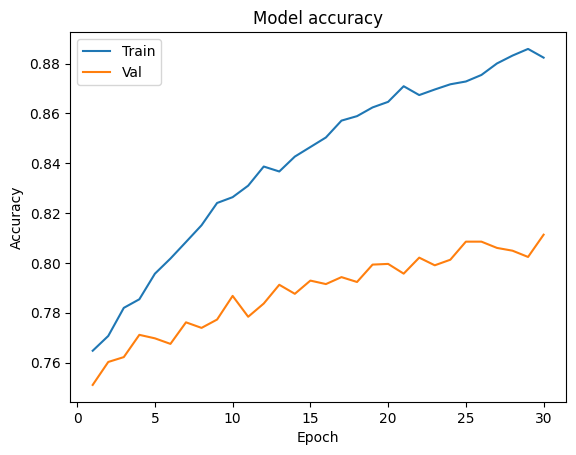

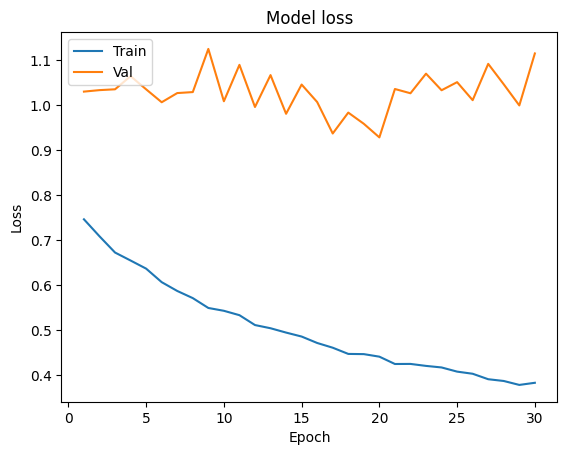

In [218]:
plot_learningCurve(history, 10)

In [219]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


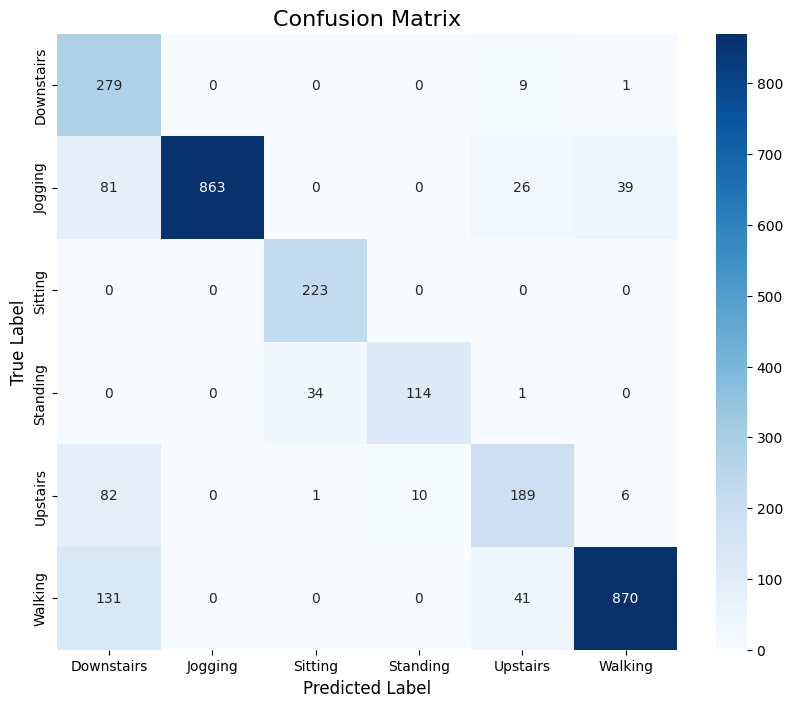

In [220]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

#혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

#시각화
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label.classes_, yticklabels=label.classes_)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [221]:
loss, accuracy = model.evaluate(x_test, y_test_hot, verbose=0)
print("="*30)
print(f"테스트 데이터 정확도 (Accuracy): {accuracy:.4f}")
print(f"테스트 데이터 손실 (Loss): {loss:.4f}")
print("="*30)

테스트 데이터 정확도 (Accuracy): 0.8460
테스트 데이터 손실 (Loss): 0.7054


In [222]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\n===== 분류 리포트 =====")
print(classification_report(y_test, y_pred, target_names=label.classes_))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

===== 분류 리포트 =====
              precision    recall  f1-score   support

  Downstairs       0.49      0.97      0.65       289
     Jogging       1.00      0.86      0.92      1009
     Sitting       0.86      1.00      0.93       223
    Standing       0.92      0.77      0.84       149
    Upstairs       0.71      0.66      0.68       288
     Walking       0.95      0.83      0.89      1042

    accuracy                           0.85      3000
   macro avg       0.82      0.85      0.82      3000
weighted avg       0.89      0.85      0.86      3000

